In [1]:
# What version of Python do you have?
import sys

import tensorflow.keras
import pandas as pd
import sklearn as sk
import tensorflow as tf
import platform

print(f"Python Platform: {platform.platform()}")
print(f"Tensor Flow Version: {tf.__version__}")
print(f"Keras Version: {tensorflow.keras.__version__}")
print()
print(f"Python {sys.version}")
print(f"Pandas {pd.__version__}")
print(f"Scikit-Learn {sk.__version__}")
gpu = len(tf.config.list_physical_devices('GPU'))>0
print("GPU is", "available" if gpu else "NOT AVAILABLE")

Python Platform: macOS-13.3.1-arm64-arm-64bit
Tensor Flow Version: 2.12.0
Keras Version: 2.12.0

Python 3.10.11 (main, Apr 20 2023, 13:58:42) [Clang 14.0.6 ]
Pandas 1.5.3
Scikit-Learn 1.2.2
GPU is available


In [2]:
from Unet_cell_body_model import *
from data_128 import *

In [3]:
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler,EarlyStopping, ReduceLROnPlateau, TensorBoard
from tensorflow.keras.optimizers import *

## Train your Unet with membrane data
membrane data is in folder membrane/, it is a binary classification task.

The input shape of image and mask are the same :(batch_size,rows,cols,channel = 1)

In [4]:
NUM_EPOCHS= 50
BATCH_SIZE = 2
NUM_TRAIN_IMAGES= 9520
NUM_VAL_IMAGES= 2380
save_to_dir_train = "/Users/behnazyazdani/unet-master/data/save_path" 
save_to_dir_val = "/Users/behnazyazdani/unet-master/data/save_path_val"

data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                     rescale = 1./255,
                    fill_mode='nearest')

myGene = trainGenerator(BATCH_SIZE,'data/train','img','lbl',data_gen_args, save_to_dir = None)
valGene = valGenerator(BATCH_SIZE,'data/val','img','lbl',data_gen_args, save_to_dir = None)


# Unet deep learning model
model = unet(img_shape=(128,128,1), out_ch=1, start_ch=64, layer=4, inc_rate=2., activation='relu', dropout=0.3,
             batchnorm=True, maxpool=True)
model.compile(optimizer = adam_v2.Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])


# setup callback function
early_stopping = EarlyStopping(patience=10, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)
model_checkpoint = ModelCheckpoint('DHM_cell.hdf5', monitor='val_loss',verbose=1, save_best_only=True)
log_dir = "logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir)


# Train the model
H = model.fit_generator(myGene,steps_per_epoch=NUM_TRAIN_IMAGES/BATCH_SIZE,epochs=NUM_EPOCHS,
                         callbacks=[ model_checkpoint,tensorboard_callback,early_stopping,reduce_lr],
                        validation_data=valGene,
                       validation_steps=NUM_VAL_IMAGES/BATCH_SIZE)

2023-04-23 22:07:00.325064: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-23 22:07:00.325074: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.
2023-04-23 22:07:00.325088: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.


Found 9520 images belonging to 1 classes.
Found 9520 images belonging to 1 classes.
Epoch 1/50


2023-04-23 22:07:02.561721: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


   1/4760 [..............................] - ETA: 3:06:06 - loss: 0.9903 - accuracy: 0.4420

2023-04-23 22:07:03.261995: I tensorflow/core/profiler/lib/profiler_session.cc:126] Profiler session initializing.
2023-04-23 22:07:03.262009: I tensorflow/core/profiler/lib/profiler_session.cc:141] Profiler session started.


   2/4760 [..............................] - ETA: 26:05 - loss: 0.9689 - accuracy: 0.4599  

2023-04-23 22:07:03.613420: I tensorflow/core/profiler/lib/profiler_session.cc:66] Profiler session collecting data.
2023-04-23 22:07:03.614228: I tensorflow/core/profiler/lib/profiler_session.cc:159] Profiler session tear down.
2023-04-23 22:07:03.615454: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230423-220700/train/plugins/profile/2023_04_23_22_07_03
2023-04-23 22:07:03.616198: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for trace.json.gz to logs/fit/20230423-220700/train/plugins/profile/2023_04_23_22_07_03/Behnazs-MacBook-Air.local.trace.json.gz
2023-04-23 22:07:03.616861: I tensorflow/core/profiler/rpc/client/save_profile.cc:137] Creating directory: logs/fit/20230423-220700/train/plugins/profile/2023_04_23_22_07_03
2023-04-23 22:07:03.617204: I tensorflow/core/profiler/rpc/client/save_profile.cc:143] Dumped gzipped tool data for memory_profile.json.gz to logs/fit/20230423-220700/train/plugins/pr

4760/4760 [==============================] - ETA: 0s - loss: 0.2779 - accuracy: 0.9262Found 2380 images belonging to 1 classes.
Found 2380 images belonging to 1 classes.


2023-04-23 22:35:27.288909: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


4760/4760 [==============================] - 1852s 389ms/step - loss: 0.2779 - accuracy: 0.9262 - val_loss: 0.1390 - val_accuracy: 0.9398

Epoch 00001: val_loss improved from inf to 0.13905, saving model to DHM_cell.hdf5
Epoch 2/50
4760/4760 [==============================] - 2103s 442ms/step - loss: 0.1006 - accuracy: 0.9517 - val_loss: 0.1005 - val_accuracy: 0.9487

Epoch 00002: val_loss improved from 0.13905 to 0.10051, saving model to DHM_cell.hdf5
Epoch 3/50
4760/4760 [==============================] - 2183s 459ms/step - loss: 0.0918 - accuracy: 0.9544 - val_loss: 0.1248 - val_accuracy: 0.9374

Epoch 00003: val_loss did not improve from 0.10051
Epoch 4/50
4760/4760 [==============================] - 2135s 448ms/step - loss: 0.0883 - accuracy: 0.9548 - val_loss: 0.1017 - val_accuracy: 0.9481

Epoch 00004: val_loss did not improve from 0.10051
Epoch 5/50
4760/4760 [==============================] - 2119s 445ms/step - loss: 0.0843 - accuracy: 0.9557 - val_loss: 0.0888 - val_accuracy:

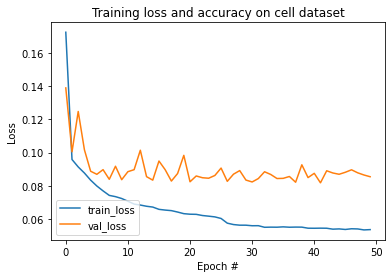

In [5]:
plt.figure()
plt.plot(H.epoch, H.history["loss"], label="train_loss")
plt.plot(H.epoch, H.history["val_loss"], label="val_loss")
plt.grid(False)  # Remove grid
plt.title("Training loss and accuracy on cell dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig("DHM_Cell_loss_curve_layer4.svg")

### Test the model on the unseen data and save the predicted results.

In [12]:
# Predict the test data
NUM_TEST_IMAGES=50
test_path= "/Users/behnazyazdani/unet-master/data/master_test/img"
file_list = [f for f in os.listdir(test_path) if f[-3:]=="tif"]
print(len(file_list)) 
file_list=os.listdir(test_path)   
testGene = testGenerator(test_path,file_list)
results = model.predict_generator(testGene,NUM_TEST_IMAGES,verbose=1)
saveResult("/Users/behnazyazdani/unet-master/data/master_test/prediction",results,file_list)

50


/Users/behnazyazdani/miniforge3/envs/tensorflow/lib/python3.9/site-packages/keras/engine/training.py:1976: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


 4/50 [=>............................] - ETA: 0s 

2023-03-14 10:37:20.927871: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:112] Plugin optimizer for device_type GPU is enabled.


50/50 [==============================] - 1s 15ms/step


### Use different methods to increase model accuracy: 

1. model = unet(img_shape=(128,128,1), out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', dropout=0.5,
             batchnorm=False, maxpool=True, upconv=True, residual=False)
             
2. model = unet(img_shape=(128,128,1), out_ch=1, start_ch=32, depth=4, inc_rate=2., activation='relu', dropout=0.5,
             batchnorm=False, maxpool=True, upconv=True, residual=False)
             
3. model = unet(img_shape=(128,128,1), out_ch=1, start_ch=32, depth=4, inc_rate=2., activation='relu', dropout=0.6,
             batchnorm=False, maxpool=True, upconv=True, residual=False)
             
4. model = unet(img_shape=(128,128,1), out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', dropout=0.3,
             batchnorm=False, maxpool=True, upconv=True, residual=False)

5. H = model.fit_generator(myGene,steps_per_epoch=1000,epochs=NUM_EPOCHS,
                        callbacks=[ model_checkpoint,tensorboard_callback,early_stopping,reduce_lr])
                        
                        NUM_EPOCHS=5
                        
                        
6. H = model.fit_generator(myGene,steps_per_epoch=1000,epochs=NUM_EPOCHS,
                        callbacks=[ model_checkpoint,tensorboard_callback,early_stopping,reduce_lr],
                       validation_data=valGene,
                      validation_steps=NUM_VAL_IMAGES/BATCH_SIZE)
                      
                      data_gen_args = dict(rotation_range=0.2,
                    width_shift_range=0.05,
                    height_shift_range=0.05,
                    shear_range=0.05,
                    zoom_range=0.05,
                    horizontal_flip=True,
                     rescale = 1./255,
                    fill_mode='nearest')
                    
7. NUM_EPOCHS= changed from 50 to 100


8. """ def upconv_block(inputs, out_channels, activation='relu', kernel_size=(3, 3), strides=(2, 2), padding='same'):
    x = Conv2DTranspose(out_channels, kernel_size, strides=strides, padding=padding)(inputs)
    x = Activation(activation)(x)
    return x """ 
    
    is used instead of 
    
    
    """" def upconv_block(inputs, out_channels, activation='relu', kernel_size=(3, 3), strides=(2, 2), padding='same'):
   x = UpSampling2D(size=strides)(inputs)
      x = Conv2D(out_channels, kernel_size, padding=padding)(x)
     x = Activation(activation)(x)
     return x """
     
     and "upconv=True" change to "upconv=False" in the following
     
     
     
9. from tm2 import *

10. from tm4 import * (tm4 is now my_model)
     
     
 #### Decrease gap in learning curve:
 
 10-1. Decrace layer from 4 going to the 3.
 
  10-2. Decrace layer from 3 going to the 2.